In [1]:
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import warnings
import scipy
warnings.simplefilter(action='ignore', category=FutureWarning)          #some code samples return useless future warnings, this suppresses them

plt.style.use("fivethirtyeight")
dataDir = "./data/"
adjMatrix = np.genfromtxt(dataDir+"adjacency_matrix.csv", delimiter=",",dtype="int")
featMatrix = np.genfromtxt(dataDir+"feature_matrix.csv", delimiter=",",dtype="int")

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
G = nx.from_numpy_matrix(adjMatrix)
scores = [0]*29
for i in range(2,31):   
    model = KMeans(n_clusters = i)
    model.fit(featMatrix)
    scores[i-2] = calinski_harabasz_score(featMatrix,model.labels_)
    print("\rProgress: [%d/29]"%(i-1),end="")

Progress: [29/29]

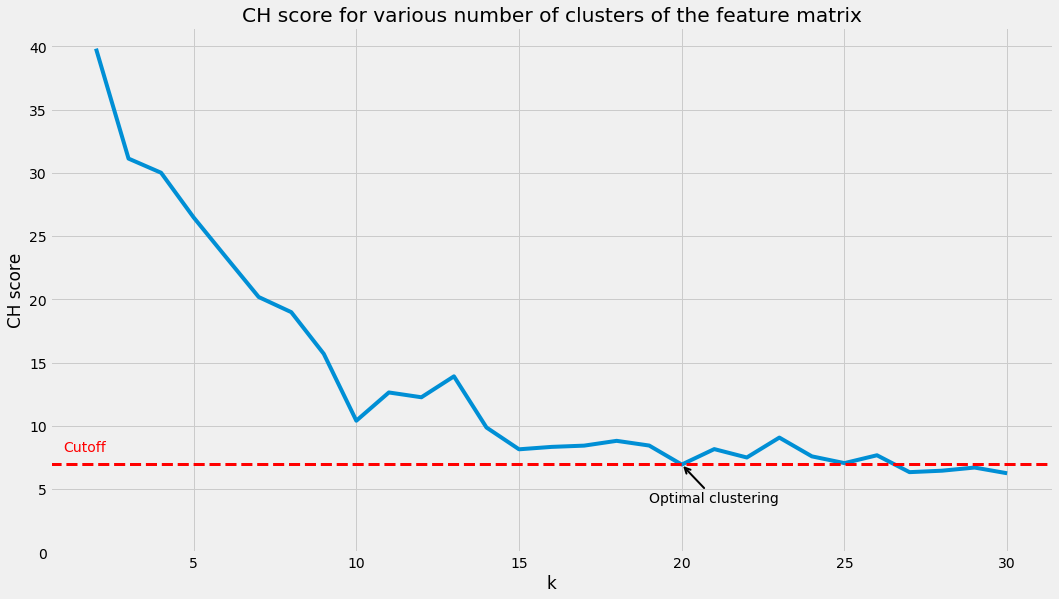

In [3]:
plt.plot(range(2,31),scores)
plt.xlabel("k")
plt.ylabel("CH score")
plt.ylim(bottom=0)
plt.title("CH score for various number of clusters of the feature matrix")
plt.gca().axhline(y=7,color="red",ls="--",lw=3)
plt.text(1,8,"Cutoff", color="red")
plt.gcf().set_size_inches(16,9)

optimalK = next(i for i, score in enumerate(scores) if score < 7) + 2
plt.annotate("Optimal clustering",(optimalK,scores[optimalK-2]),xytext=(optimalK-1,scores[optimalK-2]-3),arrowprops={"arrowstyle":"->","color":"black","lw":2})

plt.show()

In [4]:
model = KMeans(n_clusters = optimalK)
model.fit(featMatrix)

for i in range(len(G.nodes(data=False))):
    G.nodes[i]["cluster"] = model.labels_[i]

In [5]:
graphPos = nx.kamada_kawai_layout(G)

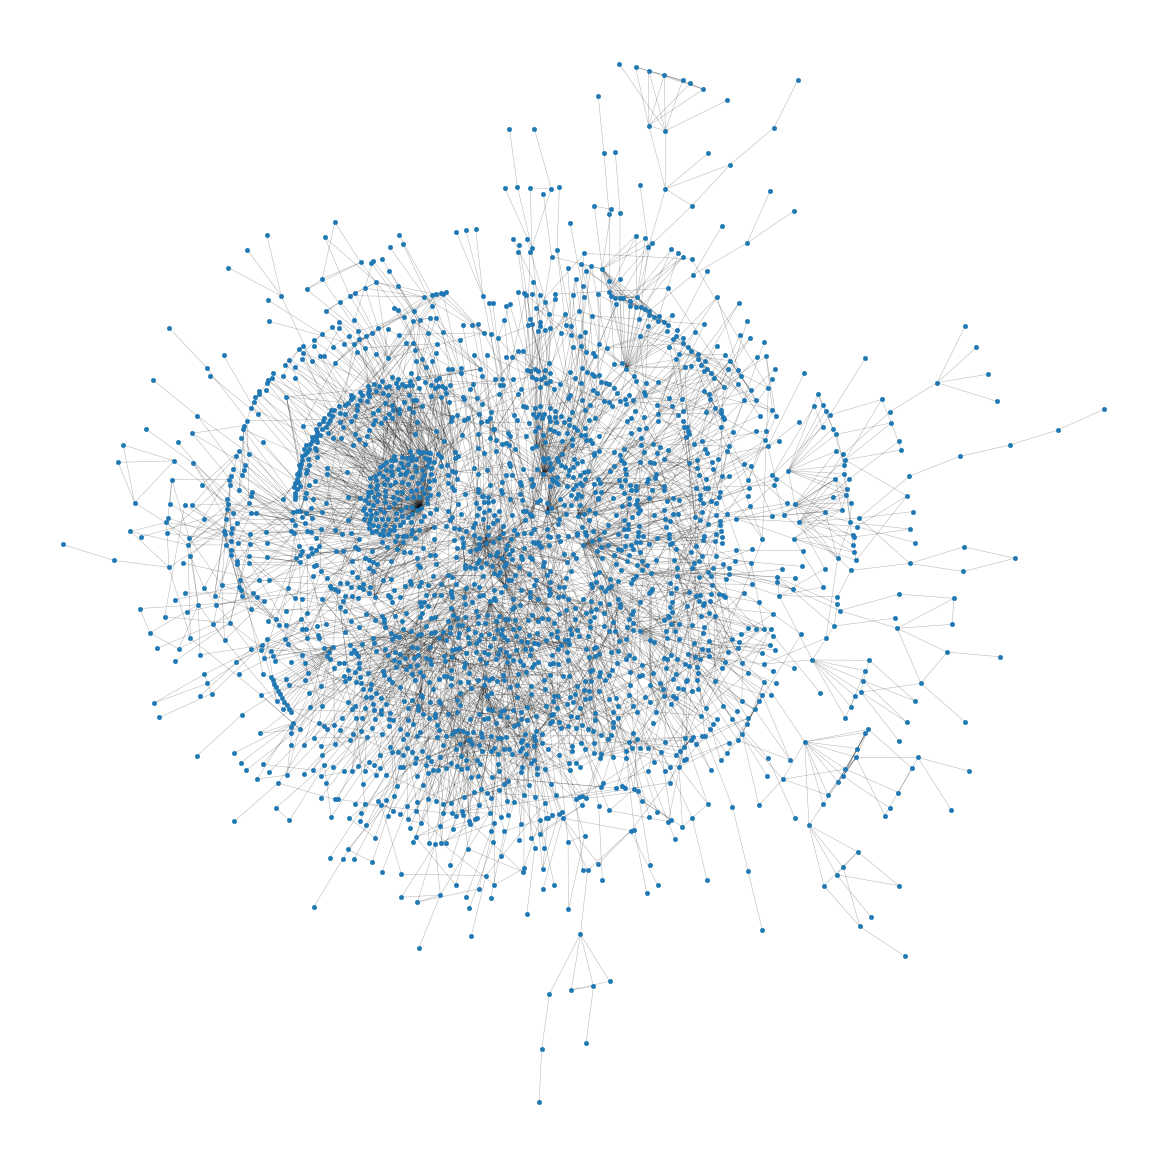

In [6]:
kwargsGraphDraw = {"pos":graphPos,"node_size":20,"width":0.5,"edge_color":(0,0,0,0.3)}
nx.draw(G, **kwargsGraphDraw)
plt.gcf().set_size_inches(16,16)

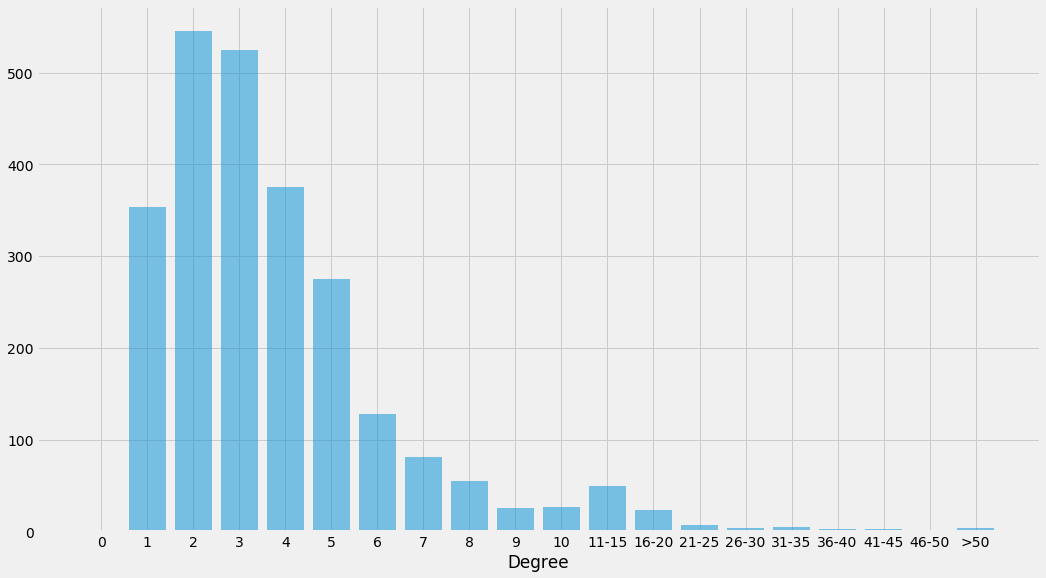

In [7]:
degreesDict = dict(G.degree())
degrees = np.sort(np.fromiter(degreesDict.values(), dtype=int))
bins = [np.count_nonzero(degrees == i) for i in range(11)]
bins += [np.count_nonzero(np.logical_and(degrees <= 5*(i+1), degrees > 5*i)) for i in range(2,10)]
bins += [np.count_nonzero(degrees > 50)]

binlabels = [str(i) for i in range(11)] + ["%d-%d"%(5*i+1,5*(i+1)) for i in range(2,10)] + [">50"]
xpos = list(range(len(bins)))

plt.bar(xpos, bins, align='center', alpha=0.5)
plt.xticks(xpos, binlabels)
plt.xlabel("Degree")

plt.gcf().set_size_inches(16,9)

In [8]:
pageranksDict = nx.pagerank(G)
pageranks = sorted(list(pageranksDict.values()))
betweennessCentralityDict = nx.betweenness_centrality(G)
betweennessCentrality = sorted(list(betweennessCentralityDict.values()))

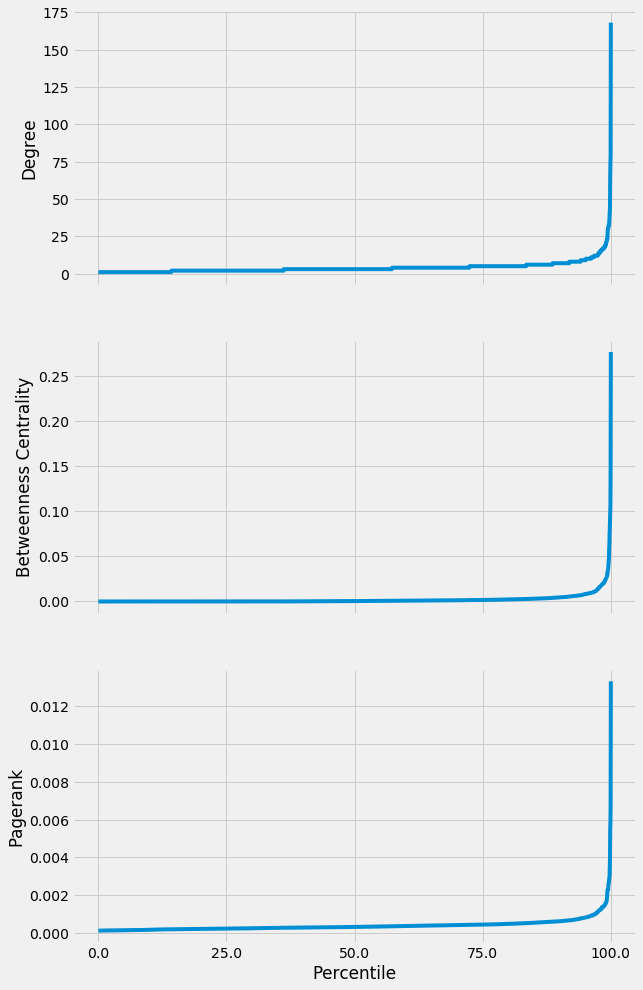

In [9]:
measures = [degrees,betweennessCentrality,pageranks]
measureLabels = ["Degree", "Betweenness Centrality","Pagerank"]
p = np.linspace(0,100,21)
f,axes = plt.subplots(3,1,sharex=True)

for i, ax in enumerate(axes):
    ax.plot(measures[i])
    ax.set_ylabel(measureLabels[i])

sparsity = 5
plt.xticks((len(pageranks)-1) * p[::sparsity]/100., map(str, p[::sparsity]))
plt.xlabel("Percentile")
f.set_size_inches(9,16)

plt.show()


In [10]:
def getRank(a,val):
    """
    list assumed sorted
    """
    return len(a) - np.searchsorted(a,val)

def kBiggestDict(k, dictionary):
    assert(k <= len(dictionary))
    return sorted(dictionary, key=dictionary.get)[-k:]

k=30
biggestDeg = kBiggestDict(k, degreesDict)
biggestPgRnk = kBiggestDict(k, pageranksDict)
biggestBtwnCent = kBiggestDict(k, betweennessCentralityDict)

commonNodes = sorted(list(set(biggestDeg).
                    intersection(biggestPgRnk).
                    intersection(biggestBtwnCent)
               ))
cols = ["Node","Degree","Degree Rank","Pagerank","Pagerank Rank","Btwn Centrality","Btwn Centrality Rank"]
df = pd.DataFrame(columns = cols)

for node in commonNodes:
    deg = degreesDict[node]
    degRank = getRank(degrees, deg)
    pgRnk = pageranksDict[node]
    pgRnkRank = getRank(pageranks, pgRnk)
    btwnCent = betweennessCentralityDict[node]
    btwnCentRank = getRank(betweennessCentrality, btwnCent)
    row = [node,deg,degRank,pgRnk,pgRnkRank,btwnCent,btwnCentRank]

    df.loc[len(df)] = row

colsToConvert = ["Node","Degree","Degree Rank","Pagerank Rank","Btwn Centrality Rank"]
df[colsToConvert] = df[colsToConvert].astype(int)
df

Node  Degree  Degree Rank  Pagerank  Pagerank Rank  Btwn Centrality  \
0     78      36            8  0.002917              8         0.059195   
1     95      32           12  0.002292             15         0.048991   
2    271      78            2  0.005511              4         0.090707   
3    542      33           10  0.002875              9         0.034706   
4    666      29           16  0.002530             13         0.035334   
5    882      19           29  0.001508             30         0.038678   
6    926      34            9  0.002759             10         0.075044   
7    977      30           15  0.002280             17         0.080662   
8   1034      21           24  0.001600             25         0.028025   
9   1122      26           17  0.002060             18         0.030915   
10  1245     168            1  0.013302              1         0.276114   
11  1418      30           15  0.002285             16         0.026220   
12  1563      74            3  0.006811              2         0.101355   
13  1672      44            5  0.003957              5         0.062338   
14  1846      65            4  0.005833              3         0.149763   
15  1894      40            7  0.003471              6         0.106109   
16  1905      32           12  0.002293             14         0.034345   

    Btwn Centrality Rank  
0                      9  
1                     10  
2                      5  
3                     15  
4                     14  
5                     13  
6                      7  
7                      6  
8                     20  
9                     17  
10                     1  
11                    22  
12                     4  
13                     8  
14                     2  
15                     3  
16                    16

In [11]:
communities = list(nx.algorithms.community.greedy_modularity_communities(G))

communitySizes = []
for i, nodes in enumerate(communities):
    communitySizes += [len(nodes)]
    for node in nodes:
        G.nodes[node]["CNM Community"] = i

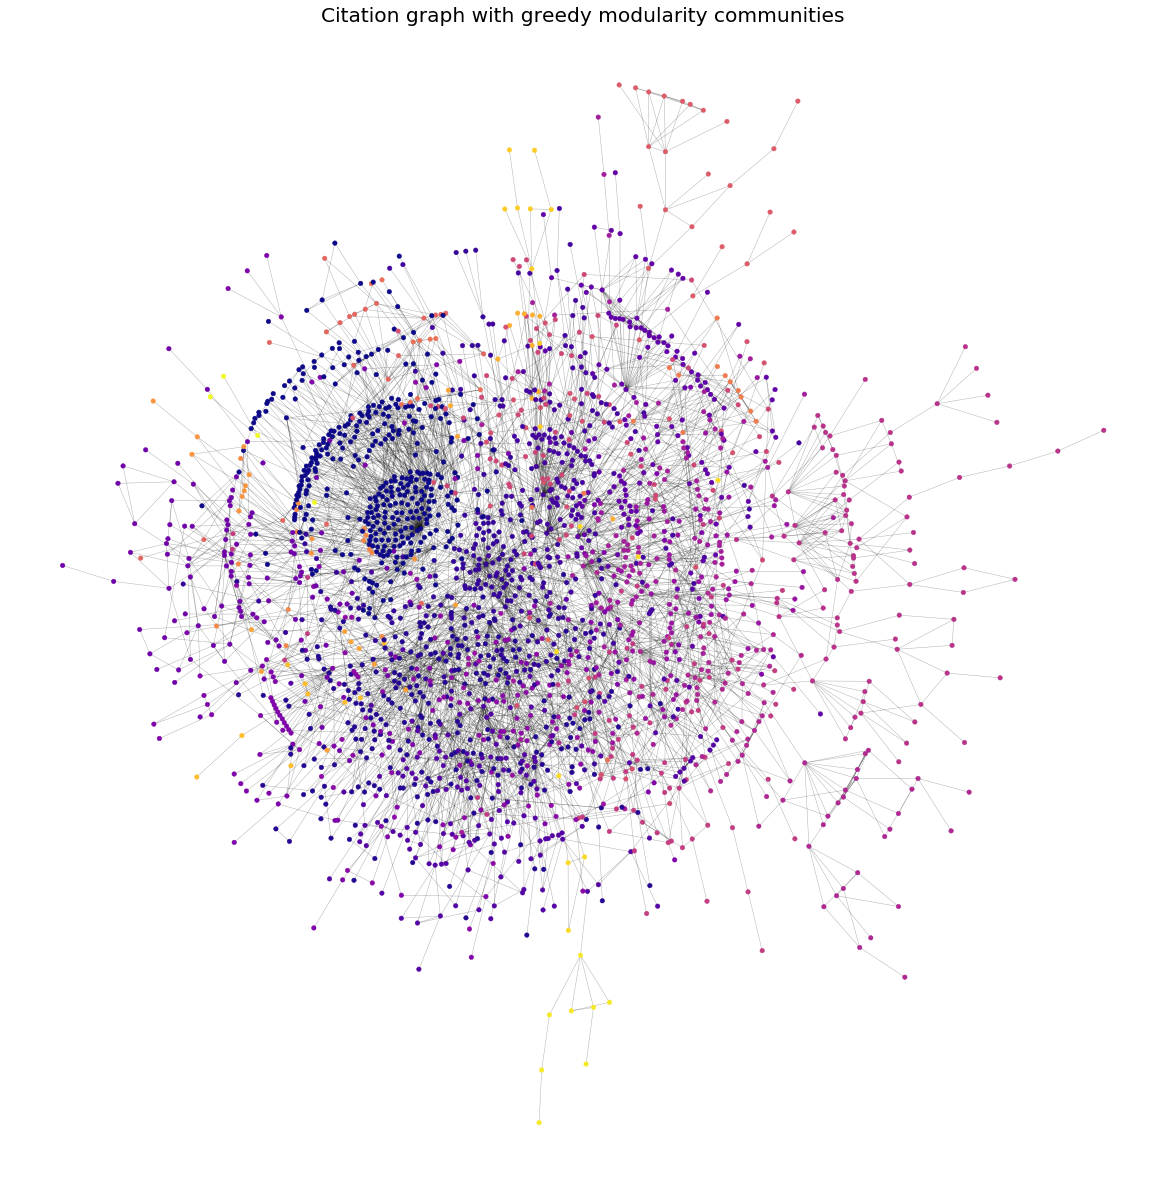

In [12]:
def getAttributeList(G, attribute):
    return list(nx.get_node_attributes(G, attribute).values())

cmapGraph = plt.cm.plasma


nx.draw(G,**kwargsGraphDraw,node_color=getAttributeList(G,"CNM Community"), cmap=cmapGraph)
plt.gcf().set_size_inches(16,16)

plt.title("Citation graph with greedy modularity communities")
plt.show()

<BarContainer object of 29 artists>

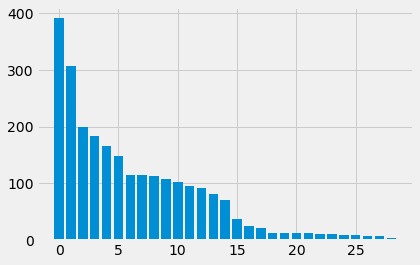

In [13]:
communitySizes = np.array(communitySizes,dtype=int)
plt.bar(list(range(len(communitySizes))),communitySizes)

In [14]:
for node in G.nodes(data = False):
    G.nodes[node]["degree"] = degreesDict[node]
    G.nodes[node]["pagerank"] = pageranksDict[node]

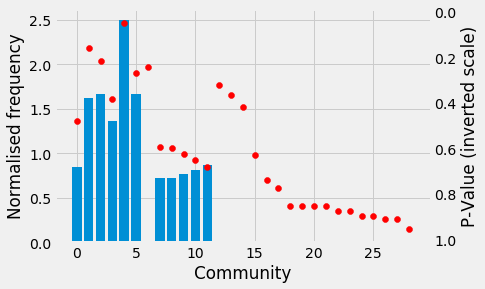

In [15]:
import scipy.stats as ss

def getPValue(n,p,x):       #probability of getting an event at least as extreme as the one observed
    n=int(n)
    x=int(x)
    hh = ss.binom(n, p)     #binomial distribution
    if (x < n*p):
        return sum([hh.pmf(i) for i in range(0,x+1)])
    else:
        return sum([hh.pmf(i) for i in range(x,n+1)])


def plotCommunityDistribution(a):
    communityDist = np.zeros(len(communitySizes))
    for nodeIndex in a:
        communityDist[G.nodes[nodeIndex]["CNM Community"]] += 1
    normalisation = communitySizes/len(G)
    pValues = [getPValue(30,normalisation[i],communityDist[i]) for i in range(len(communityDist))]
    communityDist /= normalisation*len(a)
    plt.bar(list(range(len(communityDist))),communityDist)
    plt.xlabel("Community")
    plt.ylabel("Normalised frequency")
    
    ax = plt.gca().twinx()
    ax.invert_yaxis()
    plt.grid(False)
    ax.scatter(list(range(len(pValues))),pValues,color="red")
    plt.ylabel("P-Value (inverted scale)")
    
plotCommunityDistribution(biggestDeg)

In [16]:
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import adjusted_rand_score
clusterLabels = getAttributeList(G, "cluster")
communityLabels = getAttributeList(G, "CNM Community")

adjusted_mutual_info_score(clusterLabels, communityLabels)
adjusted_rand_score(clusterLabels, communityLabels)

0.08556931750661627

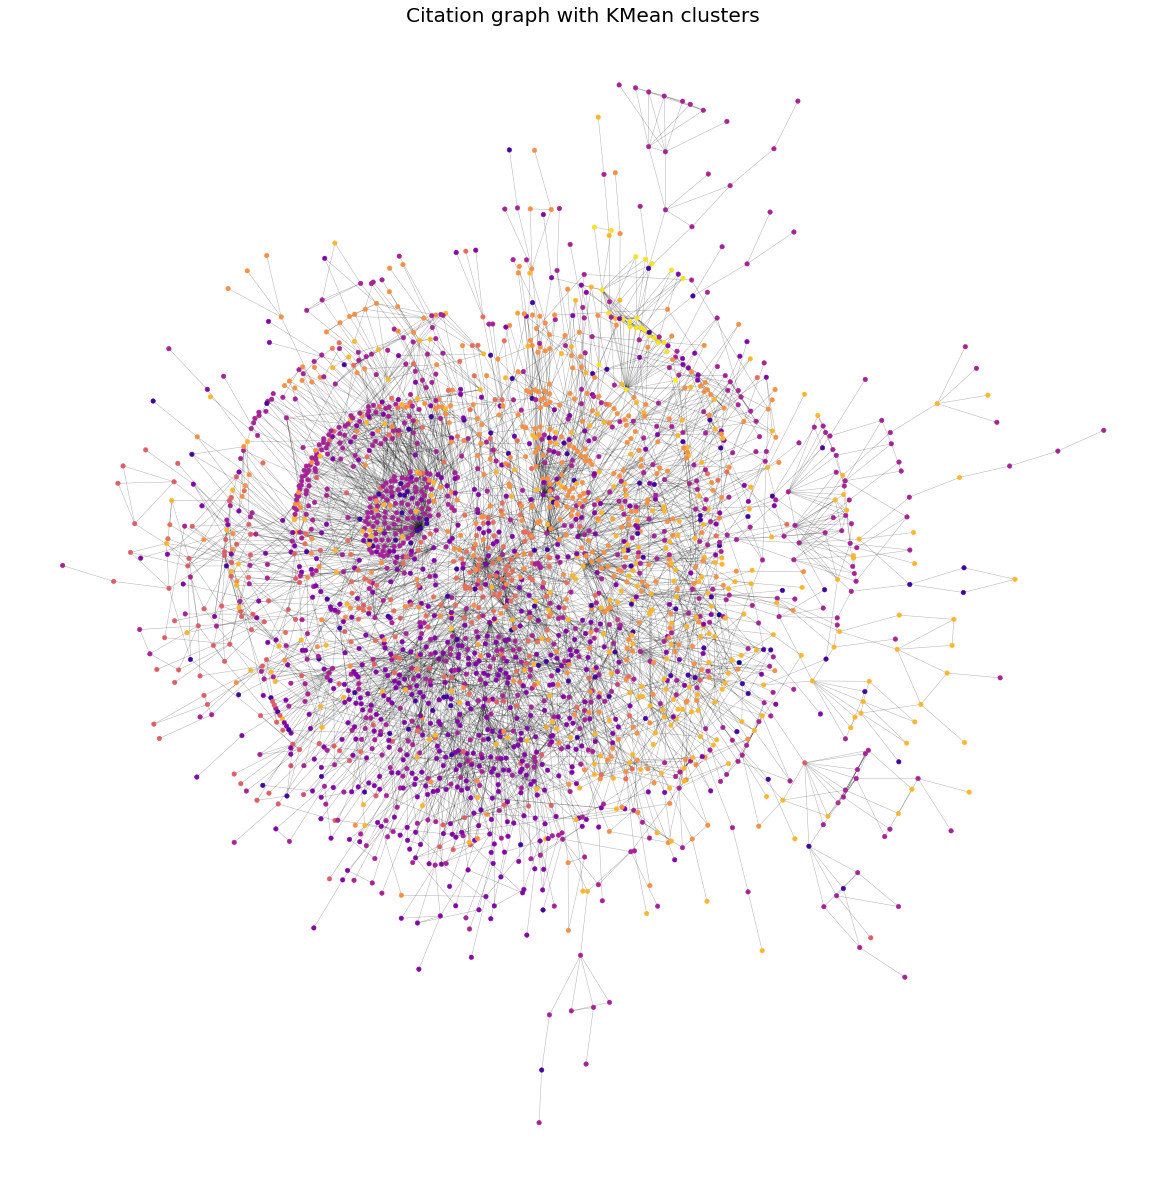

In [17]:
nx.draw(G,**kwargsGraphDraw,node_color=getAttributeList(G, "cluster"), cmap=cmapGraph)
plt.gcf().set_size_inches(16,16)

plt.title("Citation graph with KMean clusters")
plt.show()

# Task 2

In [18]:
from sklearn.datasets import fetch_openml
try:
    trainX = np.load(dataDir + "trainImg.npy")
    trainY = np.load(dataDir + "trainLbl.npy")
    testX = np.load(dataDir + "testImg.npy")
    testY = np.load(dataDir + "testImg.npy")
except: #files don't exist and need downloading
    mnist = fetch_openml('Fashion-MNIST', cache=False)
    X = mnist.data.astype('float32')
    y = mnist.target.astype('int64')
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=10000)

In [19]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

trainXFlat = trainX.reshape(-1,trainX.shape[-1]**2)
testXFlat = testX.reshape(-1,testX.shape[-1]**2)

nnScaler = MinMaxScaler()           #maps the largest value in a dataset to 1 and the smallest to 0 linearly fitting all the others

useCuda = torch.cuda.is_available()
nnScaler = nnScaler.fit(trainXFlat)          #fit the scaler to the training dataset

class NNDatasetFlat(torch.utils.data.Dataset):
    '''
    Class to store the datasets for the neural networks
    '''
    def __init__(self,X,y):
        #convert data to PyTorch tensors
        self.X = torch.from_numpy(nnScaler.transform(X)).float()
        nny = np.array(y,dtype=int)
        self.y = torch.from_numpy(nny).long()
        
        #transfer data to VRAM
        if useCuda:
            self.X = self.X.cuda()
            self.y = self.y.cuda()
    
    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self,index):
        return self.X[index],self.y[index]

In [20]:
class NNBase(nn.Module):
    '''
    Basic class from which all neural networks are inherited
    This is an abstract class which cannot be instantiated
    '''
    def __init__(self,learningRate, batchSize, verbose, validate, epochs):
        super(NNBase,self).__init__()
        self.criterion = nn.NLLLoss()
        self.learningRate = learningRate
        self.batchSize = batchSize
        self.verbose = verbose
        self.validate = validate
        self.epochs = epochs
    
    @staticmethod
    def forward(self, X):
        pass

    def reset(self):
        '''
        Resets all parameters in the network, useful if training the same network
        more than once on different datasets
        '''
        def resetWeight(m):
            if isinstance(m, nn.Linear):
                m.reset_parameters()
        self.apply(resetWeight)

    def fit(self, X, y):
        '''
        Train the network on the dataset X with labels y
        Returns in-sample and out-of-sample loss during training
        '''
        validate = self.validate    #wether to reserve some of the data for validation
        dataset = NNDatasetFlat(X,y)

        #split the dataset into validation and training if required otherwise only use training
        if validate:
            trainSize = int(0.8 * len(dataset))
            validationSize = len(dataset) - trainSize
            trainDataset, validationDataset = torch.utils.data.random_split(dataset, [trainSize, validationSize])
        else:
            trainSize = len(dataset)
            trainDataset = dataset
        self.train()        #put network in training mode, necessary to activate the dropout layers
        self.reset()        #reset all weights

        if useCuda: #compute on GPU
            self.cuda()

        optimiser = torch.optim.SGD(self.parameters(),lr=self.learningRate)
        loader = torch.utils.data.DataLoader(dataset=trainDataset,batch_size=self.batchSize,shuffle=True)

        #I know this is not the right way to do this but the efficiency loss is negligible 
        if validate:
            loaderValidation = torch.utils.data.DataLoader(dataset=validationDataset,batch_size=validationSize,shuffle=False)
            xVal, yVal = next(iter(loaderValidation))   #get all of the valiudation data (note that the batch size is the same as the dataset size)

        lossTrain = []
        lossValidation = []

        for epoch in range(self.epochs):
            currLoss = 0.0
            for pixels, classes in loader:
                optimiser.zero_grad()   #the optimiser will have the values from the previous iteration, so it needs to be reset
                outputs = self(pixels)  #apply the neural network to the predictors to get predicted ratings
                loss = self.criterion(outputs, classes) #calculate the loss

                loss.backward()  #calculate the derivative of the loss
                optimiser.step()  #update weights

                currLoss += loss.item() * pixels.size(0)    #save the current loss, we multiply by the size of the batch to normalise
            lossTrain.append(currLoss/trainSize)        #divide by the total number of elements in the training dataset
            if validate:    #calculate the loss on the validation dataset
                outputsVal = self(xVal)
                loss = self.criterion(outputsVal,yVal)
                lossValidation.append(loss.item())
                
            if ((epoch+1) % 5 == 0) and self.verbose:
                print('\rEpoch [%d/%d]'%(epoch+1, self.epochs),end='')

        if validate:
            return lossTrain, lossValidation
        return lossTrain
    
    def predict(self, X):
        self.eval()     #deactivate the dropout layer
        x = torch.from_numpy(nnScaler.transform(X)).float()  #convert X to a PyTorch tensor
        if useCuda:
            x = x.cuda()
        y = self(x).cpu().detach().numpy().argmax(axis=1)   #convert y into a numpy array, then find the maximum value and return its index, as the index corresponds exactly to the rating this will return the highest probability class
        return y

In [21]:
class MLP(NNBase):
    def __init__(self, learningRate=5e-3, batchSize=128, verbose=True, validate = True, epochs = 30):
        super(MLP, self).__init__(learningRate, batchSize, verbose, validate, epochs)
        N_PIXELS = trainXFlat.shape[1]
        N_CLASSES = 10
        N_HIDDEN = 100
        self.layerIn = nn.Linear(N_PIXELS, N_HIDDEN)
        self.layerHidden = nn.Linear(N_HIDDEN, N_HIDDEN)
        self.layerOut = nn.Linear(N_HIDDEN, N_CLASSES)
        self.activation = nn.ReLU()
        self.final = nn.Softmax()
    
    def forward(self, x):
        out = self.layerIn(x)
        out = self.activation(out)
        out = self.layerHidden(out)
        out = self.activation(out)
        out = self.layerHidden(out)
        out = self.activation(out)
        out = self.layerOut(out)
        return self.final(out)

In [22]:
from datetime import datetime
networkBase = MLP()
useCuda =False
#use GPU to accelerate if available
if useCuda:
    networkBase.cuda()

start = datetime.now()
lossBase,lossBaseVal = networkBase.fit(trainXFlat,trainY) #train network using X as predictor and y as labels
timeBase = datetime.now() - start

C:\Users\Enrico\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
Epoch [30/30]

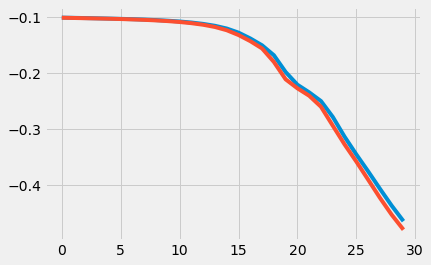

In [23]:
plt.plot(lossBase)
plt.plot(lossBaseVal)

In [24]:
class CNN(NNBase):
    def __init__(self, learningRate=5e-3, batchSize=128, verbose=True, validate = True, epochs = 30):
        super(MLP, self).__init__(learningRate, batchSize, verbose, validate, epochs)
        N_PIXELS = trainXFlat.shape[1]
        N_CLASSES = 10
        N_HIDDEN = 100
        self.layerIn = nn.Linear(N_PIXELS, N_HIDDEN)
        self.layerHidden = nn.Linear(N_HIDDEN, N_HIDDEN)
        kwargsConv = {"kernel_size": 5,"stride":1,"dilation":1}

        self.conv1 = nn.Sequential(
            nn.Conv2d(1,6,**kwargsConv),
            nn.ReLU(),
            nn.MaxPool2D(kernel_size = 2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(6,6,**kwargsConv),
            nn.ReLU(),
            nn.MaxPool2D(kernel_size = 2)
        )

        self.layerOut = nn.Sequential(
            nn.Linear(16*4*4,120),
            nn.ReLU(),
            nn.Linear(120,84),
            nn.ReLU(),
            nn.Linear(84,10)
        )
        self.final = nn.Softmax()
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.layerOut(out)
        return self.final(out)

In [25]:
from datetime import datetime
networkBase = MLP()
useCuda =False
#use GPU to accelerate if available
if useCuda:
    networkBase.cuda()

start = datetime.now()
lossBase,lossBaseVal = networkBase.fit(trainX,trainY) #train network using X as predictor and y as labels
timeBase = datetime.now() - start

ValueError: Found array with dim 3. Estimator expected <= 2.